<a href="https://colab.research.google.com/github/kamijoseph/Fake-News/blob/main/fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import spacy
import textblob
import warnings
warnings.filterwarnings("ignore")


In [ ]:
fake = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv")
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake["subject"].value_counts()

,count
subject,
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


<Axes: xlabel='subject', ylabel='count'>

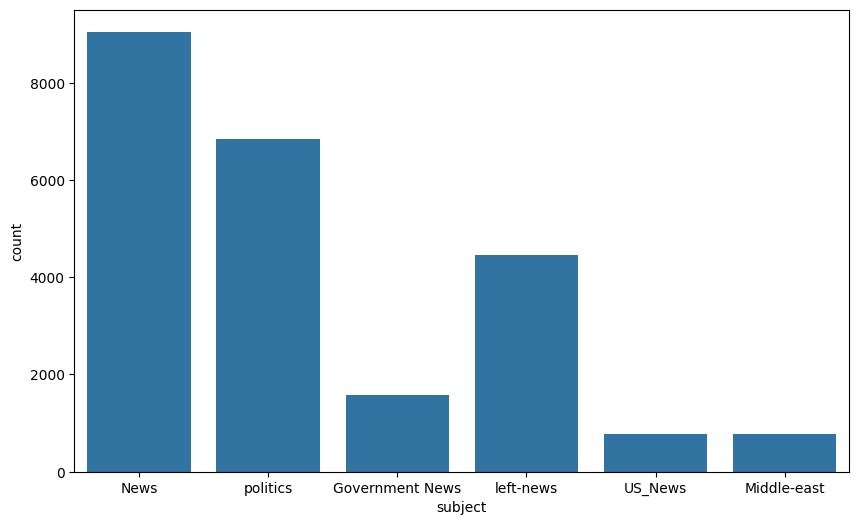

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x="subject", data=fake)

In [ ]:
# visualizing text with word cloud
text = " ".join(fake["text"].tolist())

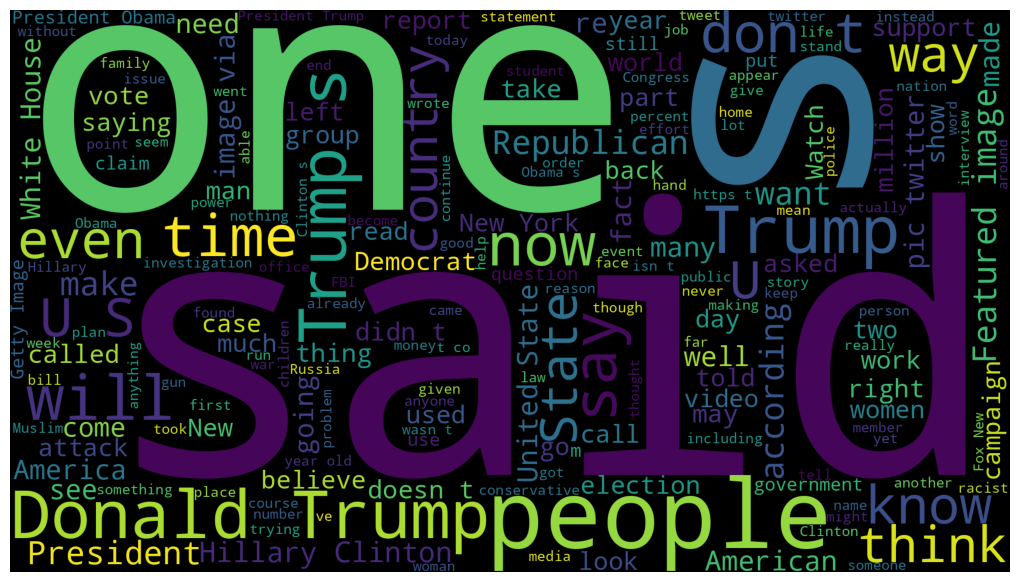

In [ ]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10, 20))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
real = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv")
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
text_real = " ".join(real["text"].tolist())

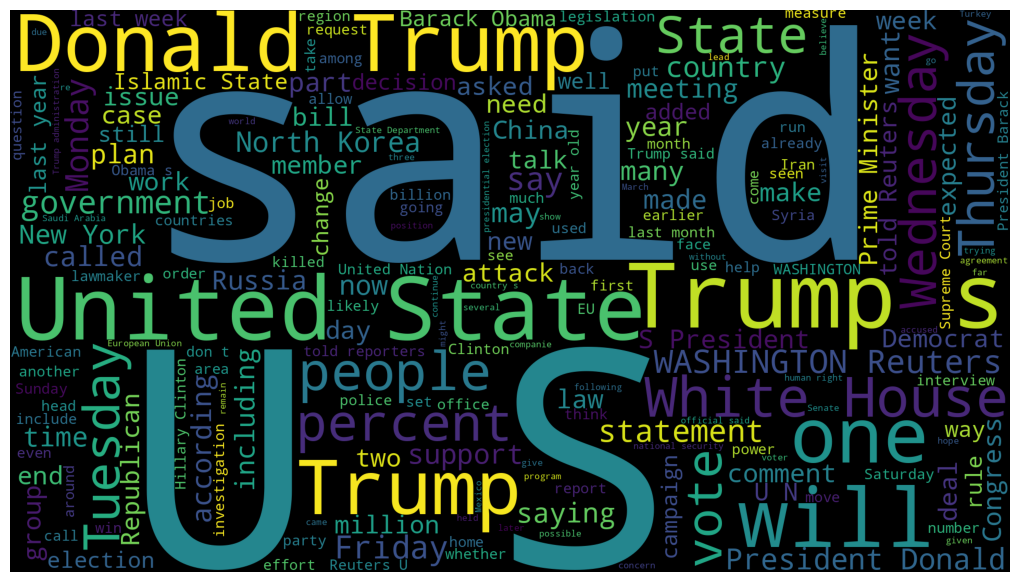

In [ ]:
wordcloud = WordCloud(width=1920, height=1080).generate(text_real)
fig = plt.figure(figsize=(10, 20))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Cleaning the data

In [ ]:
real.sample(10)

,title,text,subject,date
9437,"Sanders rejects deal on Puerto Rico, offers al...",WASHINGTON (Reuters) - Democratic presidential...,politicsNews,"May 23, 2016"
1188,Senate Democrats vow to fight drilling in Alas...,WASHINGTON (Reuters) - U.S. Senate Democrats v...,politicsNews,"October 17, 2017"
18777,Senators urge Trump administration to act on M...,WASHINGTON (Reuters) - A group of Republican a...,worldnews,"September 28, 2017"
17674,Migrant deaths in the Sahara likely twice Medi...,GENEVA (Reuters) - West African migrants tryin...,worldnews,"October 12, 2017"
13953,"Freed Pakistani militant rails against India, ...",LAHORE/ISLAMABAD (Reuters) - A newly freed Pak...,worldnews,"November 24, 2017"
17187,Xi says China will boost efforts to tackle ter...,BEIJING (Reuters) - China will step up efforts...,worldnews,"October 18, 2017"
3453,"California, other states vow to lead as Trump ...",SAN FRANCISCO (Reuters) - State governors and ...,politicsNews,"June 2, 2017"
977,First charges filed in U.S. special counsel's ...,WASHINGTON (Reuters) - A federal grand jury on...,politicsNews,"October 28, 2017"
1679,Anti-Assad nations say no to Syria reconstruct...,"NEW YORK (Reuters) - The United States, Britai...",politicsNews,"September 18, 2017"
2953,Trump denounced after assailing woman TV host ...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"June 29, 2017"


In [ ]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
  try:
    record = row.split("-", maxsplit=1)
    record[1]
    assert(len(record[0]) < 120)
  except:
    unknown_publishers.append(index)


In [ ]:
len(unknown_publishers)

222

In [ ]:
real.iloc[unknown_publishers].text

,text
7,The following statements were posted to the ve...
8,The following statements were posted to the ve...
12,The following statements were posted to the ve...
13,The following statements were posted to the ve...
14,"(In Dec. 25 story, in second paragraph, corre..."
...,...
20135,(Story corrects to million from billion in pa...
20500,"(This Sept 8 story corrects headline, clarifi..."
20667,"(Story refiles to add dropped word not , in ..."
21246,(Story corrects third paragraph to show Mosul...


In [ ]:
real.iloc[8970]

,8970
title,Graphic: Supreme Court roundup
text,
subject,politicsNews
date,"June 16, 2016"


In [ ]:
real = real.drop(8970, axis=0)

In [ ]:
publisher = []
tmp_text = []
for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append("Unknown")
  else:
    record = row.split("-", maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [ ]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
real["publisher"] = publisher
real["text"] = tmp_text

In [ ]:
real.sample(10)

,title,text,subject,date,publisher
11064,Republicans raise concerns on visa waiver bill...,Five U.S. Republican lawmakers raised concerns...,politicsNews,"January 28, 2016",WASHINGTON (Reuters)
5972,Sanctuary cities see legal holes in Trump's im...,President Donald Trump’s executive order direc...,politicsNews,"January 27, 2017",(Reuters)
9338,U.S. urges North Korea to curb actions that ra...,The United States on Tuesday condemned an atte...,politicsNews,"May 31, 2016",WASHINGTON (Reuters)
12000,U.S. citizen recaptured after Bali jail break,Indonesian police have recaptured a U.S. citiz...,worldnews,"December 18, 2017","DENPASAR, Indonesia (Reuters)"
1673,Trump choice for Russia ambassador: 'No questi...,"Former Utah Governor Jon Huntsman, President D...",politicsNews,"September 19, 2017",WASHINGTON (Reuters)
14835,Abadi says Iraq to act soon over border areas ...,"Prime Minister Haider al-Abadi, seeking to up ...",worldnews,"November 14, 2017","BAGHDAD/ERBIL, Iraq (Reuters)"
17065,"Young Japanese voters, happy with job market, ...",Young Japanese will back the ruling Liberal De...,worldnews,"October 19, 2017",TOKYO (Reuters)
7969,"If elected, Clinton under pressure to appoint ...",Democratic Party progressives intent on reinin...,politicsNews,"September 29, 2016",WASHINGTON (Reuters)
16724,Turkish soldier killed in PKK attack in southe...,A Turkish military vehicle was hit by an impro...,worldnews,"October 23, 2017",ISTANBUL (Reuters)
9149,"Democrats link guns to terrorism, turn to gun ...",President Barack Obama lamented the ease with ...,politicsNews,"June 13, 2016",WASHINGTON (Reuters)


In [ ]:
real.shape

(21416, 5)

In [ ]:
fake.shape

(23481, 4)

In [ ]:
empty_fake_index = [index for index, text in enumerate(fake.text.to_list()) if str(text).strip()==""]
len(empty_fake_index)

630

In [ ]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [ ]:
real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [ ]:
real.sample(10)

,title,text,subject,date,publisher
19540,"Erdogan, Putin to discuss Syrian peace plan ne...","Erdogan, Putin to discuss Syrian peace plan ne...",worldnews,"September 20, 2017",ISTANBUL (Reuters)
732,Trump says U.S. upholds and sticks to 'one Chi...,Trump says U.S. upholds and sticks to 'one Chi...,politicsNews,"November 9, 2017",BEIJING (Reuters)
18746,Most Germans want three-way coalition of conse...,Most Germans want three-way coalition of conse...,worldnews,"September 29, 2017",BERLIN (Reuters)
20439,"Malay woman to be Singapore president, puts mi...","Malay woman to be Singapore president, puts mi...",worldnews,"September 11, 2017",SINGAPORE (Reuters)
13793,Australian police cut chains from immigration ...,Australian police cut chains from immigration ...,worldnews,"November 27, 2017",SYDNEY (Reuters)
1068,Republicans in House launch probe of Russia de...,Republicans in House launch probe of Russia de...,politicsNews,"October 24, 2017",WASHINGTON (Reuters)
3489,Former Vice President Biden to announce politi...,Former Vice President Biden to announce politi...,politicsNews,"June 1, 2017",(Reuters)
14288,Sweden stops some new aid for Cambodia in prot...,Sweden stops some new aid for Cambodia in prot...,worldnews,"November 21, 2017",PHNOM PENH (Reuters)
15269,'Made in Syria': Refugees in Germany drive exp...,'Made in Syria': Refugees in Germany drive exp...,worldnews,"November 9, 2017",HAMBURG (Reuters)
17073,South Africa's cabinet replaces Zuma ally as h...,South Africa's cabinet replaces Zuma ally as h...,worldnews,"October 19, 2017",JOHANNESBURG (Reuters)


In [ ]:
real["text"] = real["text"].apply(lambda x: str(x).lower())
fake["text"] = fake["text"].apply(lambda x: str(x).lower())

In [ ]:
real.sample(10)

,title,text,subject,date,publisher
2337,"In rare bipartisan display, Democrats back Tru...","in rare bipartisan display, democrats back tru...",politicsNews,"August 2, 2017",WASHINGTON (Reuters)
3115,Democrats link U.S. debt limit vote to Republi...,democrats link u.s. debt limit vote to republi...,politicsNews,"June 20, 2017",WASHINGTON (Reuters)
18786,Loss of focus in fighting Islamic State after ...,loss of focus in fighting islamic state after ...,worldnews,"September 28, 2017",WASHINGTON (Reuters)
779,Democrat Ralph Northam wins Virginia governor'...,democrat ralph northam wins virginia governor'...,politicsNews,"November 8, 2017",WASHINGTON (Reuters)
19447,Trump says signs new order to widen sanctions ...,trump says signs new order to widen sanctions ...,worldnews,"September 21, 2017",NEW YORK (Reuters)
17237,Hungary eases pressure on international univer...,hungary eases pressure on international univer...,worldnews,"October 17, 2017",BUDAPEST (Reuters)
19783,Egyptian court acquits Irish citizen of murder...,egyptian court acquits irish citizen of murder...,worldnews,"September 18, 2017",CAIRO (Reuters)
1572,"Health plan would cut U.S. deficit, but leave ...","health plan would cut u.s. deficit, but leave ...",politicsNews,"September 25, 2017",WASHINGTON (Reuters)
10066,Trump calls Ford building plant in Mexico 'an ...,trump calls ford building plant in mexico 'an ...,politicsNews,"April 5, 2016",DETROIT (Reuters)
9618,Commentary: Party leaders often disliked their...,commentary: party leaders often disliked their...,politicsNews,"May 10, 2016",GOP leaders have unleashed a stunning level of...


In [ ]:
fake.sample(10)

,title,text,subject,date
16430,OBAMA’S BAILOUT OF PUERTO RICO: TAXPAYERS Take...,obama’s bailout of puerto rico: taxpayers take...,Government News,"Aug 29, 2016"
12119,FORBES LIST OF “The World’s Most Powerful Peop...,forbes list of “the world’s most powerful peop...,politics,"Dec 17, 2016"
500,Trump’s Latest Retweet Is Actually The Best P...,trump’s latest retweet is actually the best p...,News,"August 24, 2017"
19540,SMILING HOST Shows Women How To Apply Make-Up ...,smiling host shows women how to apply make-up ...,left-news,"Nov 28, 2016"
5586,"Trump Fan Calls For Lynching Hillary, Screams...","trump fan calls for lynching hillary, screams...",News,"July 6, 2016"
22527,July 4th Schoolhouse Rock: ‘Preamble to the US...,july 4th schoolhouse rock: ‘preamble to the us...,US_News,"July 4, 2016"
3870,"If You’re Mad The Popular Vote Means Nothing,...","if you’re mad the popular vote means nothing,...",News,"November 9, 2016"
8840,Economist Responsible For ‘Reaganomics’ Makes...,economist responsible for ‘reaganomics’ makes...,News,"January 10, 2016"
717,BREAKING: Trump Kicks Reince Priebus Out Of W...,breaking: trump kicks reince priebus out of w...,News,"July 28, 2017"
10904,PRESIDENT TRUMP WARNS Comey…Tweets Veiled Thre...,president trump warns comey…tweets veiled thre...,politics,"May 12, 2017"


In [ ]:
real.tail(10)

,title,text,subject,date,publisher
21407,"Mata Pires, owner of embattled Brazil builder ...","mata pires, owner of embattled brazil builder ...",worldnews,"August 22, 2017",SAO PAULO (Reuters)
21408,"U.S., North Korea clash at U.N. forum over nuc...","u.s., north korea clash at u.n. forum over nuc...",worldnews,"August 22, 2017",GENEVA (Reuters)
21409,"U.S., North Korea clash at U.N. arms forum on ...","u.s., north korea clash at u.n. arms forum on ...",worldnews,"August 22, 2017",GENEVA (Reuters)
21410,Headless torso could belong to submarine journ...,headless torso could belong to submarine journ...,worldnews,"August 22, 2017",COPENHAGEN (Reuters)
21411,North Korea shipments to Syria chemical arms a...,north korea shipments to syria chemical arms a...,worldnews,"August 21, 2017",UNITED NATIONS (Reuters)
21412,'Fully committed' NATO backs new U.S. approach...,'fully committed' nato backs new u.s. approach...,worldnews,"August 22, 2017",BRUSSELS (Reuters)
21413,LexisNexis withdrew two products from Chinese ...,lexisnexis withdrew two products from chinese ...,worldnews,"August 22, 2017",LONDON (Reuters)
21414,Minsk cultural hub becomes haven from authorities,minsk cultural hub becomes haven from authorit...,worldnews,"August 22, 2017",MINSK (Reuters)
21415,Vatican upbeat on possibility of Pope Francis ...,vatican upbeat on possibility of pope francis ...,worldnews,"August 22, 2017",MOSCOW (Reuters)
21416,Indonesia to buy $1.14 billion worth of Russia...,indonesia to buy $1.14 billion worth of russia...,worldnews,"August 22, 2017",JAKARTA (Reuters)


In [ ]:
fake.sample(10)

,title,text,subject,date
7159,A Federal Judge Just Slapped Down One Of Miss...,a federal judge just slapped down one of miss...,News,"April 1, 2016"
22901,Why Not A Probe of ‘Israel-Gate’,why not a probe of ‘israel-gate’ 21st century ...,Middle-east,"April 23, 2017"
20522,OBAMA IS FUNDING Nuclear Weapons That Will Be ...,obama is funding nuclear weapons that will be ...,left-news,"May 25, 2016"
18229,FEDERAL JUDGE STEPS IN To Review Legroom On Co...,federal judge steps in to review legroom on co...,left-news,"Jul 31, 2017"
6710,"Christian Nutjobs: ‘Eliminate Evolution, It’s...","christian nutjobs: ‘eliminate evolution, it’s...",News,"April 25, 2016"
14128,BILL O’REILLY ASKS TRUMP “Racist” Question Tha...,bill o’reilly asks trump “racist” question tha...,politics,"Apr 12, 2016"
7555,Marco Rubio NAILS IT: Trump As President Woul...,marco rubio nails it: trump as president woul...,News,"March 11, 2016"
14975,4 Yr Old Stoned By Muslim Migrant For Kicking ...,4 yr old stoned by muslim migrant for kicking ...,politics,"Nov 4, 2015"
4200,Armed Trump Supporters ‘Stand Their Ground’ O...,armed trump supporters ‘stand their ground’ o...,News,"October 14, 2016"
23279,SpaceX: Explosion Rocks Launchpad at Firm’s Ca...,spacex: explosion rocks launchpad at firm’s ca...,Middle-east,"September 1, 2016"


In [ ]:
# labels
real["class"] = 1
fake["class"] = 0
print(real.columns, fake.columns)

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object') Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')


In [ ]:
real = real[
    ["text", "class"]
]
fake = fake[
    ["text", "class"]
]
print(real.shape, fake.shape)

(21416, 2) (23481, 2)


In [ ]:
data = pd.concat([real, fake], ignore_index=True)
data.sample(10)

,text,class
7146,pence not offended by comments to him at 'hami...,1
13959,german spd to put any gov't role up for vote: ...,1
35561,socialism in venezuela: want bernie for presid...,0
8961,"u.s. senator, opposing fbi email data grabs, p...",1
16598,portugal government survives no confidence vot...,1
38579,john kerry grilled by great patriot tom cotton...,0
16904,french businesses seek clarity on iran nuclear...,1
30096,scholastic yanks children’s book for its port...,0
19025,ramping up tensions over north korea may have ...,1
18161,tokyo governor koike: no need for big change i...,1


In [ ]:
data.shape

(44897, 2)

In [ ]:
data["class"].value_counts()

,count
class,
0,23481
1,21416


In [ ]:
data.isnull().sum()

,0
text,0
class,0


In [ ]:
data["text"].head(10)

,text
0,"as u.s. budget fight looms, republicans flip t..."
1,u.s. military to accept transgender recruits o...
2,senior u.s. republican senator: 'let mr. muell...
3,fbi russia probe helped by australian diplomat...
4,trump wants postal service to charge 'much mor...
5,"white house, congress prepare for talks on spe..."
6,"trump says russia probe will be fair, but time..."
7,factbox: trump on twitter (dec 29) - approval ...
8,trump on twitter (dec 28) - global warming the...
9,alabama official to certify senator-elect jone...


In [ ]:
!pip install beautifulsoup4
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

In [ ]:
!pip install googletrans==4.0.0-rc1

In [ ]:
import preprocess_kgptalkie as ps

In [ ]:
data["text"].apply(lambda x: ps.remove_special_chars(x))
data["text"].sample(10)

,text
43584,introducing: hamish “the illusion” patterson 2...
37945,crowd of german patriots greets merkel shoutin...
19433,union protests against french labor reform los...
38105,obama takes two gas guzzling planes for sights...
6109,trump says will renegotiate nafta at 'appropri...
27688,pregnant women infected with zika triples whi...
7027,trump considering representative barletta for ...
11357,chess federation says israel excluded from sau...
8437,u.s. senator expresses concern about ag tech m...
27060,rnc bans watchdog that has attended the gop c...


In [ ]:
data["text"].head(10)

,text
0,"as u.s. budget fight looms, republicans flip t..."
1,u.s. military to accept transgender recruits o...
2,senior u.s. republican senator: 'let mr. muell...
3,fbi russia probe helped by australian diplomat...
4,trump wants postal service to charge 'much mor...
5,"white house, congress prepare for talks on spe..."
6,"trump says russia probe will be fair, but time..."
7,factbox: trump on twitter (dec 29) - approval ...
8,trump on twitter (dec 28) - global warming the...
9,alabama official to certify senator-elect jone...


In [ ]:
!pip install gensim

Vectorization using word2vec

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

In [ ]:
data.head()

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1


In [ ]:
y = data["class"].values
y

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
X = [d.split() for d in data["text"].tolist()]

In [ ]:
w2v_model = Word2Vec(
    sentences=X,
    vector_size=100,
    window=10,
    min_count=2,
    workers=multiprocessing.cpu_count()
)

In [ ]:
len(w2v_model.wv.key_to_index)

203795

In [ ]:
list(w2v_model.wv.index_to_key)

In [ ]:
vector = w2v_model.wv.get_vector("love")
vector

array([-2.3117309 ,  0.8561867 , -2.1992238 ,  1.1220717 ,  1.9126458 ,
       -1.0702497 , -1.9349461 , -3.6962585 , -4.067105  , -3.590665  ,
       -2.6286182 ,  0.6554563 , -0.663344  , -0.1320369 ,  1.3775576 ,
       -1.3342037 ,  0.9279479 , -2.8452413 ,  0.6853794 ,  0.9782975 ,
        0.40607378,  3.388889  ,  1.0706284 , -0.1889344 , -1.7656411 ,
        1.7296917 , -3.0464616 ,  1.3277462 , -2.4037116 ,  5.867672  ,
       -1.1160872 ,  0.00744942, -2.1326365 ,  1.7722794 , -2.2671862 ,
        0.72430426, -5.852495  , -3.6704376 , -2.1103234 , -2.1493742 ,
        2.429258  ,  0.21619362,  2.148137  ,  0.91432333,  2.9996445 ,
        5.1141076 , -1.1107471 , -1.3843997 ,  0.53575253, -0.9312428 ,
        1.5184553 ,  2.74035   , -1.3526438 ,  0.16943868, -0.34010643,
        1.8828163 , -2.591438  ,  1.1371212 ,  0.2116706 , -4.0591245 ,
        3.642651  ,  1.6826092 ,  0.6572882 ,  0.61371297,  2.1431274 ,
        1.4008169 , -0.46272638, -0.29234064, -0.4693713 ,  3.17

In [ ]:
X

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
tokenizer.word_index

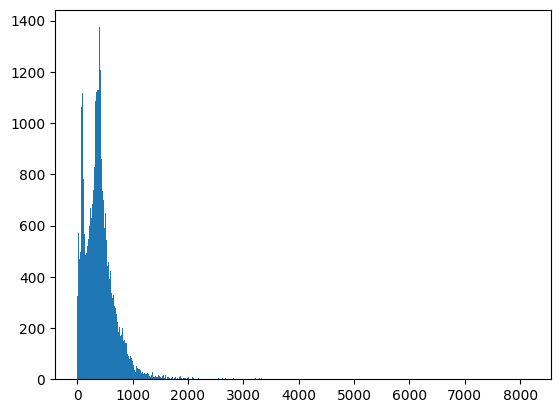

In [85]:
plt.hist(
    [len(x) for x in X],
    bins = 700
)
plt.show()